In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import sys
import os
import matplotlib.pyplot as plt
import scipy.stats
import math
from new_code.options import Options
from new_code import dataset
from new_code.disco_gan_with_risk import DiscoGANRisk
from new_code.disco_gan_model import DiscoGAN
from new_code import utils
from new_code.inference import *
from new_code.error_bound_calc_functions import *

# sys.path.insert(0, 'C:\projects\DLCourse\DistanceGAN_boosting')
# sys.path.insert(0, 'C:\projects\DLCourse\DistanceGAN_boosting\discogan_arch')
sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting')
sys.path.insert(0, '/home/deepjunior/anaconda3/projects/gil_eyal_oran_csdl_proj/DistanceGAN_boosting/discogan_arch')


def initial_boosting_calc(pretrained_g10_path, pretrained_g20_path, data_a, data_b):

    options_fixed = Options(task_name='edges2shoes', model_arch='discogan', which_epoch_load=3,
                            not_all_samples=False, batch_size=64, fixed_g1=True, start_from_pretrained_g1=True,
                            start_from_pretrained_g2=True,
                            pretrained_g1_path_A=pretrained_g10_path, pretrained_g1_path_B=pretrained_g10_path,
                            pretrained_g2_path_A=pretrained_g20_path, pretrained_g2_path_B=pretrained_g20_path)
#     fixed_disco_risk = DiscoGANRisk(options_fixed)
    G1_0_A, G1_0_B, G2_0_A, G2_0_B = load_models(options_fixed)

    J_loss_order, J_loss_val, groud_truth_loss = samples_order_by_loss_from_filenames(data_a, data_b,
                                                                                      G1_0_B, G2_0_B,
                                                                                      options_fixed.cuda,
                                                                                      options_fixed.batch_size)
    return J_loss_order, J_loss_val, groud_truth_loss


def return_partial_ordered(data_a, data_b, J_loss_order, keep_portion=0.5):
    n_keep = int(np.round(keep_portion*len(J_loss_order)))
    data_a_reorder = reorder_samples_by_loss(J_loss_order, data_a)
    data_b_reorder = reorder_samples_by_loss(J_loss_order, data_b)
#     data_a_reorder, data_b_reorder = data_a[J_loss_order[:n_keep]], data_b[J_loss_order[:n_keep]]

    return data_a_reorder[:n_keep], data_b_reorder[:n_keep]


def boosting_train(pretrained_g11_path, pretrained_g21_path, data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val,
                   phase=2, over_train=2, boosting_phases=1, b_weights=None):
    new_g1_path = pretrained_g11_path + '_boosting1_g1'
    new_g2_path = pretrained_g21_path + '_boosting1_g2'
    options_no_risk = Options(task_name='edges2shoes', model_arch='discogan', which_epoch_load=phase,
                              epoch_size=27*over_train, batch_size=64, start_from_pretrained_g1=True,
                              pretrained_g1_path_A=pretrained_g11_path, pretrained_g1_path_B=pretrained_g11_path,
                              model_path=new_g1_path, fixed_g1=False)
    discogan_model_no_risk = DiscoGAN(options_no_risk)
    print('Starting to train G1_1')
    discogan_model_no_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G1_1. Saved at:')
    print(new_g1_path)
    options_with_risk = Options(task_name='edges2shoes', model_arch='discogan', epoch_size=(phase+1)*27*over_train,
                                which_epoch_load=boosting_phases, start_from_pretrained_g1=True, one_sample_train=True,
                                pretrained_g1_path_A=new_g1_path, pretrained_g1_path_B=new_g1_path,
                                fixed_g1=True, batch_size=64, model_path=new_g2_path)
    discogan_model_with_risk = DiscoGANRisk(options_with_risk)

    print('Starting G2_1')
    discogan_model_with_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G2_1. Saved at:')
    print(new_g2_path)
    return new_g1_path, new_g2_path


def define_options_for_inference(g1_0_path, g2_0_path, g1_1_path, g2_1_path, phase=2, over_train=2):
    options1 = Options(task_name='edges2shoes', model_arch='discogan', result_path='./results/temp/',
                       model_path='./models/temp/', pretrained_g1_path_A=g1_0_path, pretrained_g1_path_B=g1_0_path,
                       pretrained_g2_path_A=g2_0_path, pretrained_g2_path_B=g2_0_path,
                       which_epoch_load=3, batch_size=64, test_mode=True)

    options2 = Options(task_name='edges2shoes', model_arch='discogan', result_path='./results/temp/',
                       model_path='./models/temp/', pretrained_g1_path_A=g1_1_path, pretrained_g1_path_B=g1_1_path,
                       pretrained_g2_path_A=g2_1_path, pretrained_g2_path_B=g2_1_path,
                       which_epoch_load=3, batch_size=64, test_mode=True)
    return options1, options2

In [ ]:
if __name__ == "__main__":
    pretrained_g10_path, pretrained_g20_path = './saved_models/discogan_shoes2edges/g1_only',\
                                               './saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed'
    data_a, data_b = dataset.get_edges2shoes()
    data_len = min(len(data_a),len(data_b))
    data_a, data_b = data_a[:data_len], data_b[:data_len]

    data_A_val, data_B_val = dataset.get_edges2shoes(test=True)
    J_loss_order_0, J_loss_val_0, ground_truth_loss_0 = initial_boosting_calc(pretrained_g10_path, pretrained_g20_path,
                                                                              data_a=data_a, data_b=data_b)
    data_a_reorder_0, data_b_reorder_0 = return_partial_ordered(data_a, data_b, J_loss_order_0, keep_portion=0.5)
    over_train = int(round(1 / (len(data_a_reorder_0) / len(data_a))))
    g1_1_path, g2_1_path = boosting_train(pretrained_g10_path, pretrained_g20_path, data_a_reorder_0, data_b_reorder_0,
                                          data_A_val, data_B_val, phase=2, over_train=over_train, boosting_phases=1 ,
                                          b_weights=None)
    ### STILL NEED TO DEFINE A BETTER WAY TO LOAD THE MODEL PHASE    
    options_0, options_1 = define_options_for_inference(pretrained_g10_path, pretrained_g20_path, pretrained_g10_path + '_boosting1_g1', pretrained_g20_path + '_boosting1_g2', phase=2, over_train=2)
    gt_loss_g0, gt_loss_boosting, gt_loss_g1, error_bound_g0, error_bound_boosting, error_bound_g1, error_bound_order_g0, error_bound_order_g1 =\
    run_test_with_boosting(options_0, options_1, mode='ranking')

# DEBUG 

### Run training G2 only

In [2]:
def boosting_train_only_g2_train(pretrained_g11_path, pretrained_g21_path, data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val,
                                 phase=2, over_train=2, boosting_phases=1, b_weights=None):
    new_g1_path = pretrained_g11_path + '_boosting1_g1'
    new_g2_path = pretrained_g21_path + '_boosting1_g2'
    options_no_risk = Options(task_name='edges2shoes', model_arch='discogan', which_epoch_load=phase,
                              epoch_size=27*over_train, batch_size=64, start_from_pretrained_g1=True,
                              pretrained_g1_path_A=pretrained_g11_path, pretrained_g1_path_B=pretrained_g11_path,
                              model_path=new_g1_path, fixed_g1=False)
    discogan_model_no_risk = DiscoGAN(options_no_risk)
#     print('Starting to train G1_1')
#     discogan_model_no_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G1_1. Saved at:')
#     print(new_g1_path)
    options_with_risk = Options(task_name='edges2shoes', model_arch='discogan', epoch_size=(phase+1)*27*over_train,
                                which_epoch_load=boosting_phases, start_from_pretrained_g1=True, one_sample_train=True,
                                pretrained_g1_path_A=new_g1_path, pretrained_g1_path_B=new_g1_path,
                                fixed_g1=True, batch_size=64, model_path=new_g2_path)
    discogan_model_with_risk = DiscoGANRisk(options_with_risk)

    print('Starting G2_1')
    discogan_model_with_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G2_1. Saved at:')
    print(new_g2_path)
    return new_g1_path, new_g2_path

In [3]:
pretrained_g10_path, pretrained_g20_path = './saved_models/discogan_shoes2edges/g1_only',\
                                           './saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed'
data_a, data_b = dataset.get_edges2shoes()
data_len = min(len(data_a),len(data_b))
data_a, data_b = data_a[:data_len], data_b[:data_len]

data_A_val, data_B_val = dataset.get_edges2shoes(test=True)
J_loss_order_0, J_loss_val_0, ground_truth_loss_0 = initial_boosting_calc(pretrained_g10_path, pretrained_g20_path,
                                                                          data_a=data_a, data_b=data_b)
data_a_reorder_0, data_b_reorder_0 = return_partial_ordered(data_a, data_b, J_loss_order_0, keep_portion=0.5)
over_train = int(round(1 / (len(data_a_reorder_0) / len(data_a))))
g1_1_path, g2_1_path = boosting_train_only_g2_train(pretrained_g10_path, pretrained_g20_path, data_a_reorder_0, data_b_reorder_0, 
                                                    data_A_val, data_B_val, phase=2, over_train=over_train, boosting_phases=1 ,
                                                    b_weights=None)
options_0, options_1 = define_options_for_inference(pretrained_g10_path, pretrained_g20_path, pretrained_g10_path + '_boosting1_g1', pretrained_g20_path + '_boosting1_g2', phase=2, over_train=2)

gt_loss_g0, gt_loss_boosting, gt_loss_g1, error_bound_g0, error_bound_boosting, error_bound_g1, error_bound_order_g0, error_bound_order_g1 =\
run_test_with_boosting(options_0, options_1, mode='ranking')

N/A%|                                                           |ETA:  --:--:--

Number of samples:  24912
Number of iterations:  390


 99%|########################################################### |ETA:  0:00:00

Done training G1_1. Saved at:
Starting G2_1
195 batches per epoch


epoch #0|N/A%|                                                  |ETA:  --:--:--/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
epoch #0|  0%|                                                   |ETA:  0:13:26

Models checkpoint saved at ./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2, version 0


epoch #0| 99%|################################################## |ETA:  0:00:00/home/deepjunior/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
epoch #51| 28%|##############                                    |ETA:  0:01:25

Models checkpoint saved at ./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2, version 1


epoch #102| 56%|###########################                      |ETA:  0:00:48

Models checkpoint saved at ./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2, version 2


epoch #153| 85%|#########################################        |ETA:  0:00:16

Models checkpoint saved at ./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2, version 3


epoch #161| 99%|################################################ |ETA:  0:00:00

Done training G2_1. Saved at:
./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2


FileNotFoundError: [Errno 2] No such file or directory: '../saved_models/discogan_shoes2edges_epochs98_g2_with_fixed_g1_all_examples/model_gen_A_G1-3'

### Don't run any training

In [2]:
def boosting_no_train(pretrained_g11_path, pretrained_g21_path, data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val,
                      phase=2, over_train=2, boosting_phases=1, b_weights=None):
    new_g1_path = pretrained_g11_path + '_boosting1_g1'
    new_g2_path = pretrained_g21_path + '_boosting1_g2'
    options_no_risk = Options(task_name='edges2shoes', model_arch='discogan', which_epoch_load=phase,
                              epoch_size=27*over_train, batch_size=64, start_from_pretrained_g1=True,
                              pretrained_g1_path_A=pretrained_g11_path, pretrained_g1_path_B=pretrained_g11_path,
                              model_path=new_g1_path, fixed_g1=False)
    discogan_model_no_risk = DiscoGAN(options_no_risk)
#     print('Starting to train G1_1')
#     discogan_model_no_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G1_1. Saved at:')
#     print(new_g1_path)
    options_with_risk = Options(task_name='edges2shoes', model_arch='discogan', epoch_size=(phase+1)*27*over_train,
                                which_epoch_load=boosting_phases, start_from_pretrained_g1=True, one_sample_train=True,
                                pretrained_g1_path_A=new_g1_path, pretrained_g1_path_B=new_g1_path,
                                fixed_g1=True, batch_size=64, model_path=new_g2_path)
    discogan_model_with_risk = DiscoGANRisk(options_with_risk)

    print('Starting G2_1')
#     discogan_model_with_risk.train(data_a_reorder_0, data_b_reorder_0, data_A_val, data_B_val, b_weights=None)
    print('Done training G2_1. Saved at:')
    print(new_g2_path)
    return new_g1_path, new_g2_path

In [4]:
pretrained_g10_path, pretrained_g20_path = './saved_models/discogan_shoes2edges/g1_only',\
                                           './saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed'
data_a, data_b = dataset.get_edges2shoes()
data_len = min(len(data_a),len(data_b))
data_a, data_b = data_a[:data_len], data_b[:data_len]

data_A_val, data_B_val = dataset.get_edges2shoes(test=True)
J_loss_order_0, J_loss_val_0, ground_truth_loss_0 = initial_boosting_calc(pretrained_g10_path, pretrained_g20_path,
                                                                          data_a=data_a, data_b=data_b)
data_a_reorder_0, data_b_reorder_0 = return_partial_ordered(data_a, data_b, J_loss_order_0, keep_portion=0.5)
over_train = int(round(1 / (len(data_a_reorder_0) / len(data_a))))
g1_1_path, g2_1_path = boosting_no_train(pretrained_g10_path, pretrained_g20_path, data_a_reorder_0, data_b_reorder_0, 
                                         data_A_val, data_B_val, phase=2, over_train=over_train, boosting_phases=1,
                                         b_weights=None)
options_0, options_1 = define_options_for_inference(pretrained_g10_path, pretrained_g20_path, pretrained_g10_path + '_boosting1_g1', pretrained_g20_path + '_boosting1_g2', phase=2, over_train=2)

gt_loss_g0, gt_loss_boosting, gt_loss_g1, error_bound_g0, error_bound_boosting, error_bound_g1, error_bound_order_g0, error_bound_order_g1 =\
run_test_with_boosting(options_0, options_1, mode='ranking')

N/A%|                                                           |ETA:  --:--:--

Number of samples:  24912
Number of iterations:  390


 99%|########################################################### |ETA:  0:00:00

Done training G1_1. Saved at:
Starting G2_1
Done training G2_1. Saved at:
./saved_models/discogan_shoes2edges/g2_one-sample_g1-fixed_boosting1_g2


 50%|##############################                              |ETA:  0:00:00

Number of samples:  200
Number of iterations:  4


 50%|##############################                              |ETA:  0:00:00

Number of samples:  200
Number of iterations:  4
Original Loss: 0.13809392720460892 Boosting Loss: 0.11275730684399604


# Plots

In [45]:
print("G1_0 Loss: {:.3}, Boosting Loss: {:.3}, G1_1 Loss: {:.3}".format(np.mean(gt_loss_g0), np.mean(gt_loss_boosting), np.mean(gt_loss_g1)))

G1_0 Loss: 0.138, Boosting Loss: 0.113, G1_1 Loss: 0.0993


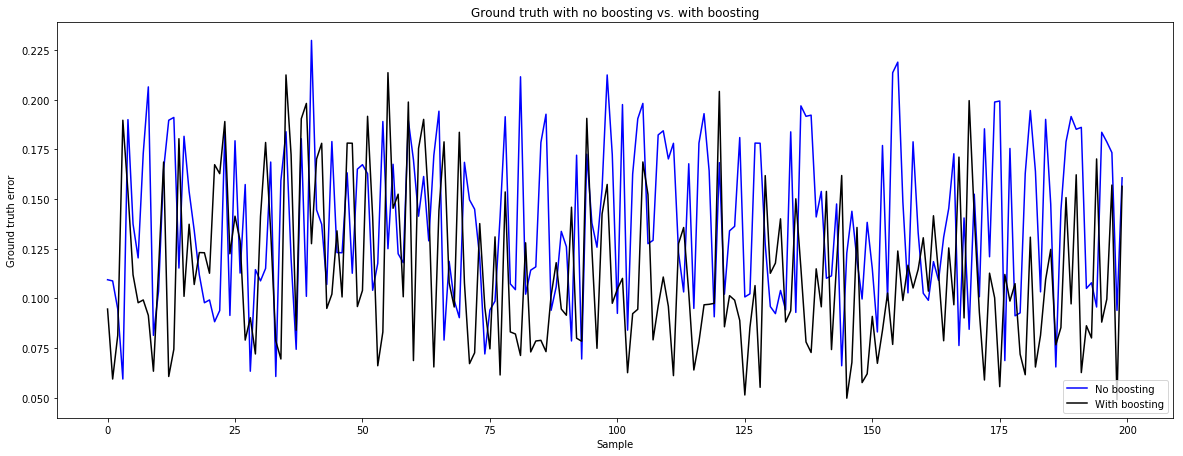

In [5]:
# Plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.subplot(2,1,1)

plt.plot(gt_loss_g0, 'b')
plt.plot(gt_loss_boosting,'k')

plt.title('Ground truth with no boosting vs. with boosting')
plt.xlabel('Sample')
plt.ylabel('Ground truth error')
plt.legend(['No boosting' ,'With boosting'], loc=4)

# plt.subplot(3,1,2)
# plt.plot(J_loss_val[:200], 'b')
# plt.plot(groud_truth_loss[:200],'r')

# plt.title('(Zoom in) Error bound vs. ground truth')
# plt.xlabel('Sample')
# plt.ylabel('Error')
# plt.legend(['Error bound' ,'Ground truth'], loc=4)


In [11]:
# Read images
# print('Low error - use G1_0: ',first_round_idx)
# print('High error - use G1_1: ',second_round_idx)

hard_images = (error_bound_order_g0[:10])
easy_images = error_bound_order_g0[len(error_bound_order_g0)-10:]
hard_images_files = []
easy_images_files = []
for idx in range(10):
    hard_images_files.append(data_B_val[hard_images[idx]])
    easy_images_files.append(data_B_val[easy_images[idx]])


# images = model_discogan_with_risk.get_the_images(data_style_A, data_style_B, 0, with_path=True)
data_b_val_images_A_hard = read_images(hard_images_files, 'A', options_0.image_size)
data_b_val_images_B_hard = read_images(hard_images_files, 'B', options_0.image_size)
print('Edges (data_b_val_images_A) size: ', np.shape(data_b_val_images_A_hard))
print('Shoes (data_b_val_images_B) size: ', np.shape(data_b_val_images_B_hard))
data_b_val_images_A_hard = Variable(torch.FloatTensor(data_b_val_images_A_hard))
data_b_val_images_B_hard = Variable(torch.FloatTensor(data_b_val_images_B_hard))
if options_0.cuda:
    data_b_val_images_A_hard = data_b_val_images_A_hard.cuda(0)
    data_b_val_images_B_hard = data_b_val_images_B_hard.cuda(0)
    
# images = model_discogan_with_risk.get_the_images(data_style_A, data_style_B, 0, with_path=True)
data_b_val_images_A_easy = read_images(easy_images_files, 'A', options_0.image_size)
data_b_val_images_B_easy = read_images(easy_images_files, 'B', options_0.image_size)
print('Edges (data_b_val_images_A_easy) size: ', np.shape(data_b_val_images_A_easy))
print('Shoes (data_b_val_images_B) size: ', np.shape(data_b_val_images_B_easy))
data_b_val_images_A_easy = Variable(torch.FloatTensor(data_b_val_images_A_easy))
data_b_val_images_B_easy = Variable(torch.FloatTensor(data_b_val_images_B_easy))
if options_0.cuda:
    data_b_val_images_A_easy = data_b_val_images_A_easy.cuda(0)
    data_b_val_images_B_easy = data_b_val_images_B_easy.cuda(0)    

Edges (data_b_val_images_A) size:  (10, 3, 64, 64)
Shoes (data_b_val_images_B) size:  (10, 3, 64, 64)
Edges (data_b_val_images_A_easy) size:  (10, 3, 64, 64)
Shoes (data_b_val_images_B) size:  (10, 3, 64, 64)


## Load Models

In [15]:
G1_0_A, G1_0_B, G2_0_A, G2_0_B = load_models(options_0)
G1_1_A, G1_1_B, G2_1_A, G2_1_B = load_models(options_1)

In [16]:
figures_hard = np.zeros((40,3,64,64))
figures_hard[0:10,:,:,:] = data_b_val_images_B_hard[:, :, :, :].data.cpu().numpy() # Domain A (Edges)
figures_hard[10:20,:,:,:] = G1_0_A(data_b_val_images_B_hard[:, :, :, :]).data.cpu().numpy() # G1(A)-->B
figures_hard[20:30,:,:,:] = G1_1_A(data_b_val_images_B_hard[:, :, :, :]).data.cpu().numpy() # G2(A)-->B
figures_hard[30:40,:,:,:] = data_b_val_images_A_hard[:, :, :, :].data.cpu().numpy() # Domain B (Shoes)

figures_easy = np.zeros((40,3,64,64))
figures_easy[0:10,:,:,:] = data_b_val_images_B_easy[:, :, :, :].data.cpu().numpy() # Domain A (Edges)
figures_easy[10:20,:,:,:] = G1_0_A(data_b_val_images_B_easy[:, :, :, :]).data.cpu().numpy() # G1(A)-->B
figures_easy[20:30,:,:,:] = G1_1_A(data_b_val_images_B_easy[:, :, :, :]).data.cpu().numpy() # G2(A)-->B
figures_easy[30:40,:,:,:] = data_b_val_images_A_easy[:, :, :, :].data.cpu().numpy() # Domain B (Shoes)

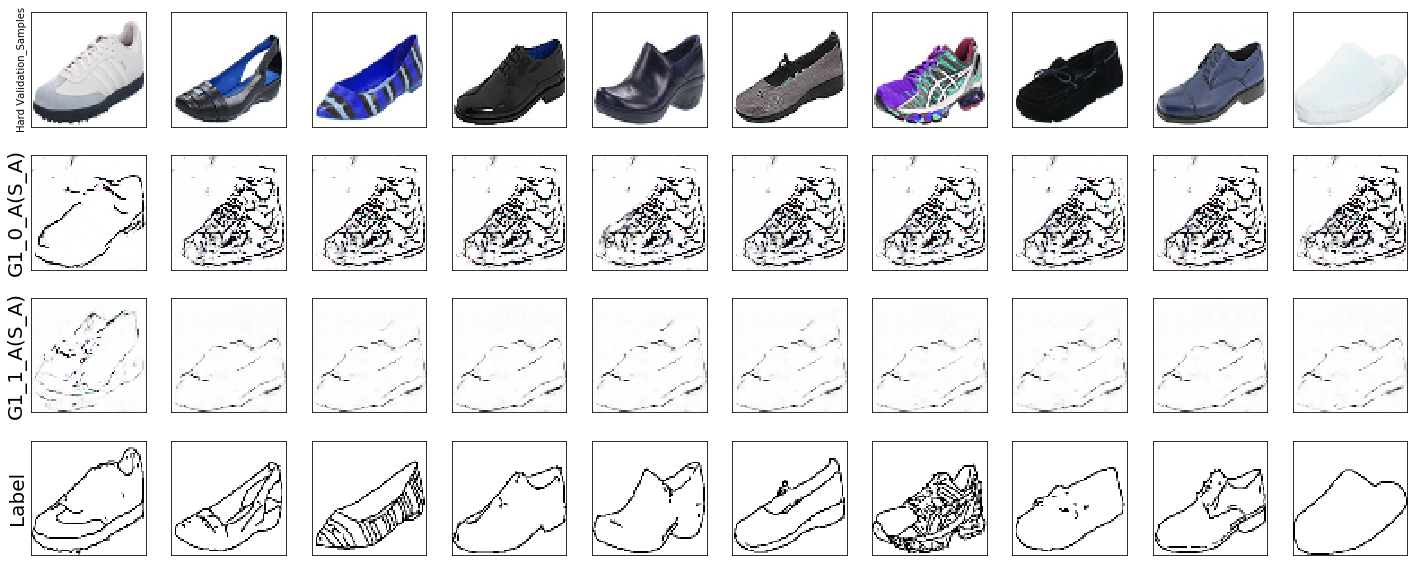

In [17]:
%matplotlib inline
plt.figure(figsize=(20, 8))
for idx, current_image in enumerate(figures_hard[0:10]):
    plt.subplot(4, 10, idx+1)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('Hard Validation_Samples', fontsize='10')
for idx, current_image in enumerate(figures_hard[10:20]):
    plt.subplot(4, 10, idx+1+10)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('G1_0_A(S_A)', fontsize='20')
plt.tight_layout()
for idx, current_image in enumerate(figures_hard[20:30]):
    plt.subplot(4, 10, idx+1+20)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('G1_1_A(S_A)', fontsize='20')
plt.tight_layout()
for idx, current_image in enumerate(figures_hard[30:40]):
    plt.subplot(4, 10, idx+1+30)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('Label', fontsize='20')
plt.tight_layout()

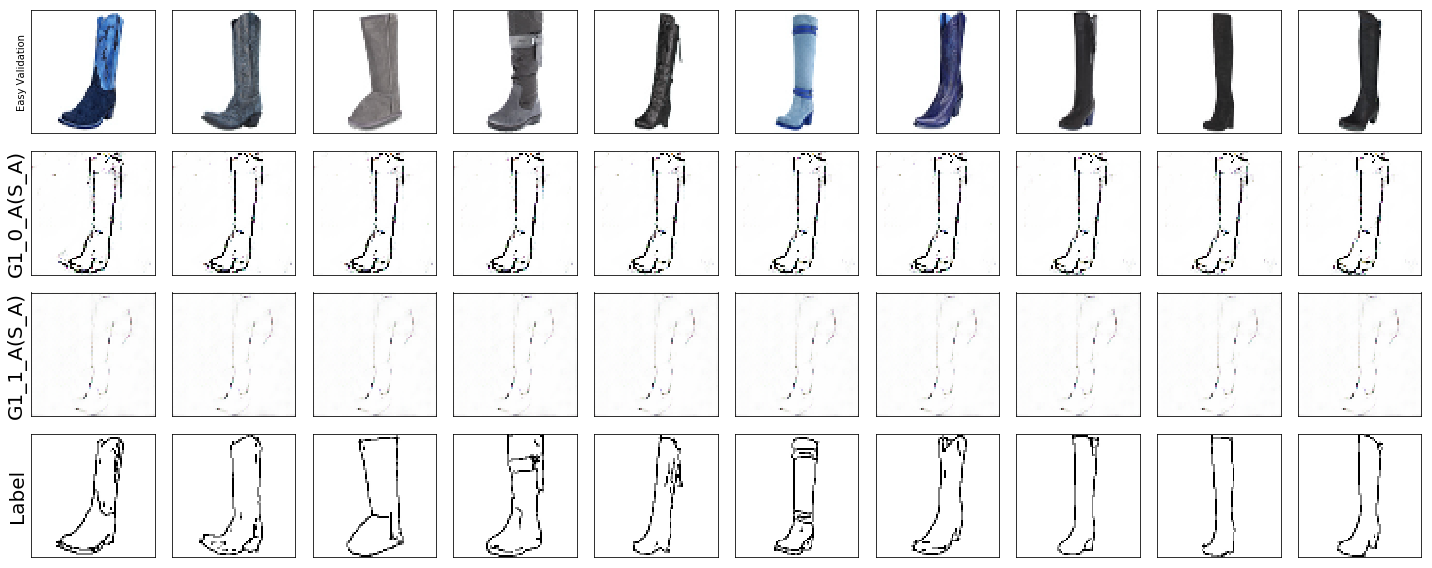

In [18]:
%matplotlib inline
plt.figure(figsize=(20, 8))
for idx, current_image in enumerate(figures_easy[0:10]):
    plt.subplot(4, 10, idx+1)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('Easy Validation', fontsize='10')
for idx, current_image in enumerate(figures_easy[10:20]):
    plt.subplot(4, 10, idx+1+10)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('G1_0_A(S_A)', fontsize='20')
plt.tight_layout()
for idx, current_image in enumerate(figures_easy[20:30]):
    plt.subplot(4, 10, idx+1+20)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('G1_1_A(S_A)', fontsize='20')
plt.tight_layout()
for idx, current_image in enumerate(figures_easy[30:40]):
    plt.subplot(4, 10, idx+1+30)
    plt.imshow(current_image.transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    if idx==0:
        plt.ylabel('Label', fontsize='20')
plt.tight_layout()

### Ground truth error for G1_1

In [ ]:
# J_loss_order_val3, J_loss_val_val3, groud_truth_loss_val3 = samples_order_by_loss_from_filenames(
#     data_a_val, data_b_val, G1_1_B, G2_1_B, G1_1_A, G2_1_A, options_infer, n_batch=64, print_freq=100)
# g1_1_only_ground_truth_loss = np.average(groud_truth_loss_val3)
# print(g1_1_only_ground_truth_loss)

(0, 0.22987699508666992)

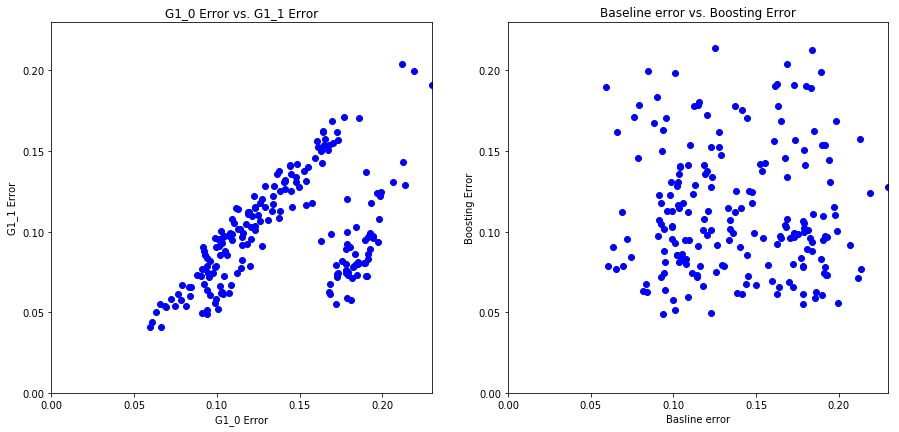

In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15) 
plt.subplot(2,2,1)
plt.plot(gt_loss_g0, gt_loss_g1,'ob')
plt.title('G1_0 Error vs. G1_1 Error')
plt.xlabel('G1_0 Error')
plt.ylabel('G1_1 Error')
plt.xlim(0, max(np.max(gt_loss_g0),np.max(gt_loss_g1)))
plt.ylim(0, max(np.max(gt_loss_g0),np.max(gt_loss_g1)))

plt.subplot(2,2,2)
plt.plot(gt_loss_g0, gt_loss_boosting,'ob')
plt.title('Baseline error vs. Boosting Error')
plt.xlabel('Basline error')
plt.ylabel('Boosting Error')
plt.xlim(0, max(np.max(gt_loss_g0),np.max(gt_loss_boosting)))
plt.ylim(0, max(np.max(gt_loss_g0),np.max(gt_loss_boosting)))

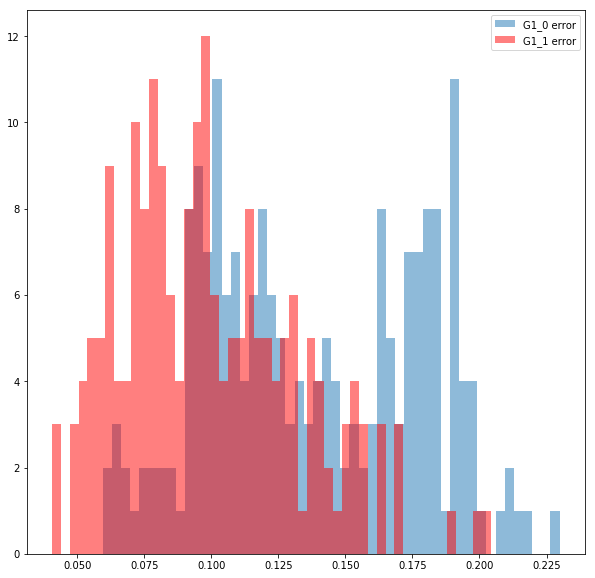

In [43]:
plt.rcParams['figure.figsize'] = (10, 10) 
plt.hist(gt_loss_g0, 50, alpha=0.5, label='G1_0 error')
plt.hist(gt_loss_g1, 50, alpha=0.5, label='G1_1 error',color='red')
plt.legend(loc='upper right')
plt.show()
